       S1_F1      S1_F2      S1_F3       S1_F4       S1_F5       S1_F6  \
0  67.588115  83.274425  89.333050  121.477569  162.415102  182.838358   
1  51.920103  70.251762  89.979643  122.138222  158.690533  180.149196   
2  65.583934  84.550628  92.836348  126.160038  176.341144  189.389240   
3  80.441871  85.546586  96.707123  114.467412  195.486408  214.458322   
4  50.654863  65.219062  83.301976  137.704902  179.048341  199.471501   

        S1_F7       S1_F8       S1_F9      S1_F10  ...       S4_F8  \
0  218.546805  239.852535  253.000097  265.280812  ...  173.572436   
1  201.690267  225.682263  277.222101  300.708606  ...  160.143979   
2  245.691326  288.321549  333.154596  375.833766  ...  181.657745   
3  235.078857  246.789397  369.131024  389.604178  ...  213.006825   
4  248.377708  266.183093  311.872188  320.815023  ...  172.625035   

        S4_F9      S4_F10      S4_F11      S4_F12      S4_F13      S4_F14  \
0  175.295667  176.191071  185.517841  187.536515  188.19

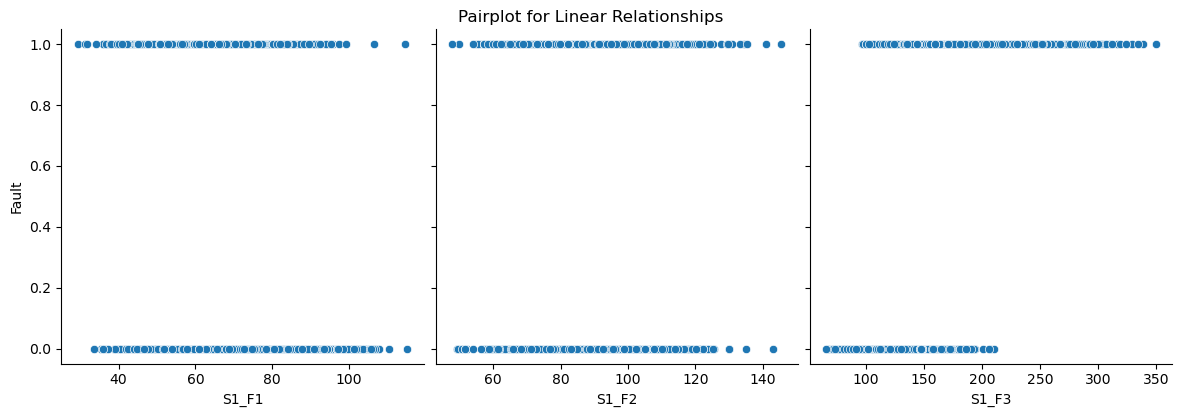

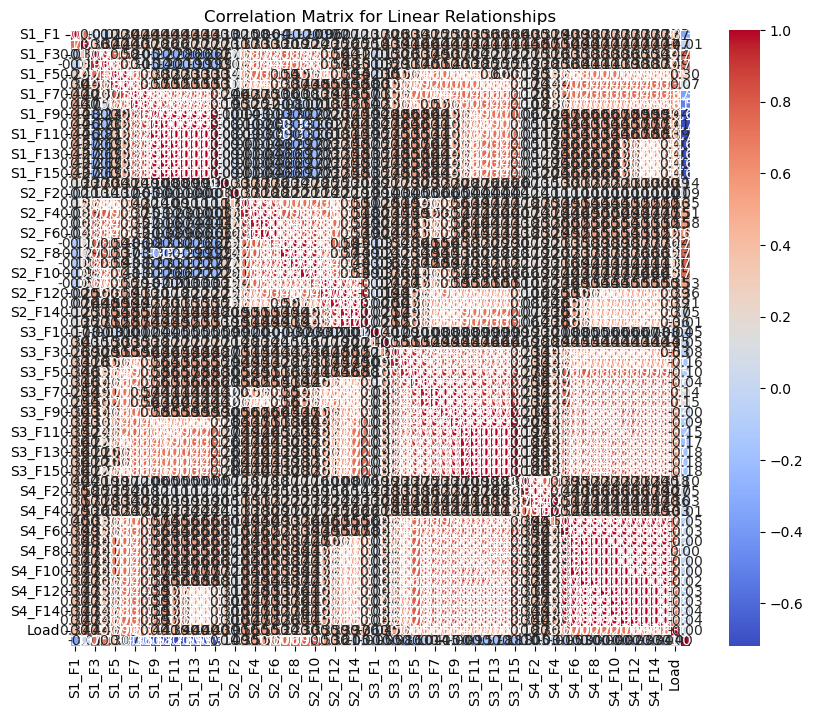

Epoch 1/50
194/194 [==============================] - 3s 8ms/step - loss: 0.4568 - val_loss: 0.3166
Epoch 2/50
194/194 [==============================] - 1s 5ms/step - loss: 0.3337 - val_loss: 0.2782
Epoch 3/50
194/194 [==============================] - 1s 5ms/step - loss: 0.3122 - val_loss: 0.2606
Epoch 4/50
194/194 [==============================] - 1s 6ms/step - loss: 0.2928 - val_loss: 0.2699
Epoch 5/50
194/194 [==============================] - 1s 5ms/step - loss: 0.2793 - val_loss: 0.2519
Epoch 6/50
194/194 [==============================] - 1s 6ms/step - loss: 0.2717 - val_loss: 0.2558
Epoch 7/50
194/194 [==============================] - 1s 5ms/step - loss: 0.2674 - val_loss: 0.2574
Epoch 8/50
194/194 [==============================] - 1s 5ms/step - loss: 0.2662 - val_loss: 0.2585
Epoch 9/50
194/194 [==============================] - 1s 5ms/step - loss: 0.2612 - val_loss: 0.2520
Epoch 10/50
194/194 [==============================] - 1s 6ms/step - loss: 0.2574 - val_loss: 0.2539

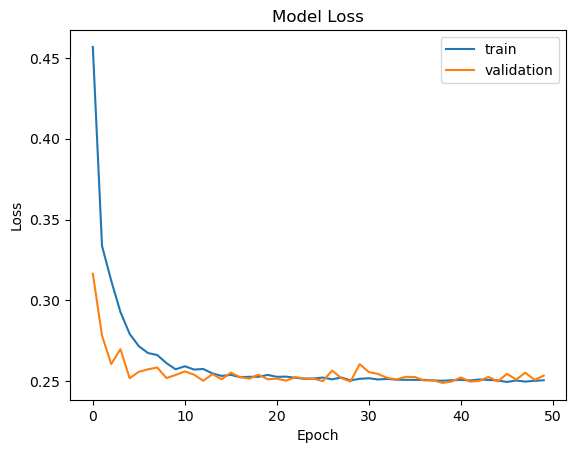

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Load and inspect the dataset
data = pd.read_csv(r"C:\Users\athar\Downloads\Processed_final_data.csv")
print(data.head())
print(data.columns)

# Adjust column names according to the actual dataset
# Here, we assume 'S1_F1', 'S1_F2', 'S1_F3' are feature columns and 'Fault' is the target column
feature_columns = ['S1_F1', 'S1_F2', 'S1_F3']  # Adjust this list based on actual columns
target_column = 'Fault'  # Adjust this based on the actual target column

# Pairplot for scatter plots and histograms
sns.pairplot(data, x_vars=feature_columns, y_vars=[target_column], height=4)
plt.suptitle('Pairplot for Linear Relationships', y=1.02)
plt.show()

# Correlation matrix
correlation_matrix = data.corr()

# Heatmap for correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix for Linear Relationships')
plt.show()

# Function to split data into training and testing sets
def split_data(data):
    X = data[feature_columns]
    y = data[target_column]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = split_data(data)

# Standardizing the data
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert scaled data back to DataFrame
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

# Function to create sequences for RNN
def create_sequences(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X.iloc[i:(i + time_steps)].values)
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

# Create sequences with scaled data
time_steps = 5
X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train, time_steps)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test, time_steps)

# Build the RNN model
model = Sequential()
model.add(SimpleRNN(units=100, return_sequences=True, input_shape=(time_steps, X_train_seq.shape[2])))
model.add(Dropout(0.2))
model.add(SimpleRNN(units=100))
model.add(Dropout(0.2))
model.add(Dense(1))

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

# Train the model
history = model.fit(X_train_seq, y_train_seq, epochs=50, batch_size=16, validation_split=0.2, verbose=1)

# Evaluate the model
y_pred = model.predict(X_test_seq)
mse = mean_squared_error(y_test_seq, y_pred)
mae = mean_absolute_error(y_test_seq, y_pred)
r2 = r2_score(y_test_seq, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'Mean Absolute Error: {mae}')
print(f'R² Score: {r2}')

# Plotting the loss over epochs
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()
